# Solving the $\mathbb{p}^\top$ integral

In this notebook we validate our expressions for the occultation solution vector, $\mathbb{s}^\top$, which we compute using Green's theorem.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from IPython.display import Latex
from scipy.special import binom

np.seterr(invalid="ignore", divide="ignore");

## Limits of integration

In the paper, we presented the expressions for the point of intersection between the occultor limb and the occulted limb and the intersection between the occultor limb and the terminator, both parameterized in terms of the angle $\phi$:

In [68]:
def compute_phi(b, theta, bo, ro):
    """
    Return the limits of integration for the pT integral.
    
    Note that we're in the F' frame, so theta is actually theta'.
    """
    # Occultor/occulted intersection
    sign = np.array([1, -1])
    phi0 = 0.5 * np.pi + sign * (
        np.arcsin((1 - ro ** 2 - bo ** 2) / (2 * bo * ro)) - 0.5 * np.pi
    )

    # Occultor/terminator intersection
    # Must solve a quartic!
    xo = bo * np.sin(theta)
    yo = bo * np.cos(theta)
    A = (1 - b ** 2) ** 2
    B = -4 * xo * (1 - b ** 2)
    C = -2 * (
        b ** 4
        + ro ** 2
        - 3 * xo ** 2
        - yo ** 2
        - b ** 2 * (1 + ro ** 2 - xo ** 2 + yo ** 2)
    )
    D = -4 * xo * (b ** 2 - ro ** 2 + xo ** 2 + yo ** 2)
    E = (
        b ** 4
        - 2 * b ** 2 * (ro ** 2 - xo ** 2 + yo ** 2)
        + (ro ** 2 - xo ** 2 - yo ** 2) ** 2
    )
    x = np.roots([A, B, C, D, E])
    
    # Exclude imaginary roots
    x = np.array([xi.real for xi in x if np.abs(xi.imag) < 1e-8])
    
    # Exclude roots not on the terminator
    y = b * np.sqrt(1 - x ** 2)
    xprime = x * np.cos(theta) - y * np.sin(theta)
    yprime = x * np.sin(theta) + y * np.cos(theta)
    good = np.abs(xprime ** 2 + (yprime - bo) ** 2 - ro ** 2) < 1e-8
    x = x[good]

    phi1 = theta + np.arctan2(b * np.sqrt(1 - x ** 2) - yo, x - xo)

    return np.append(phi0, phi1)

Let's verify that these expressions give us the correct points of intersection for the example in Figure 16:

In [77]:
def plot(b, theta, bo, ro, phi):
    """Plot the occultor, the occulted body, and the day/night terminator in frame F'."""
    # Equation of a rotated ellipse
    x0 = np.linspace(-1, 1, 1000)
    y0 = b * np.sqrt(1 - x0 ** 2)
    x = x0 * np.cos(theta) - y0 * np.sin(theta)
    y = x0 * np.sin(theta) + y0 * np.cos(theta)

    # Plot the curves
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.add_artist(plt.Circle((0, 0), 1, ec="k", fc="none"))
    ax.add_artist(plt.Circle((0, bo), ro, ec="k", fc="none"))
    ax.plot(x, y)

    # Indicate the angles
    ax.plot(0, bo, "k.")
    ax.plot([0, ro], [bo, bo], "k--", lw=1)
    for i, phi_i in enumerate(phi):
        x = ro * np.cos(phi_i)
        y = bo + ro * np.sin(phi_i)
        ax.plot([0, x], [bo, y], "k-", lw=1, alpha=0.5)
        ax.plot(x, y, "C1o")
        ax.annotate(
            i + 1,
            xy=(x, y),
            xycoords="data",
            xytext=(20 * x, 20 * (y - bo)),
            textcoords="offset points",
            va="center",
            ha="center",
        )

    # Appearance
    ax.set_aspect(1)
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.25)
    ax.axis("off")
    return ax

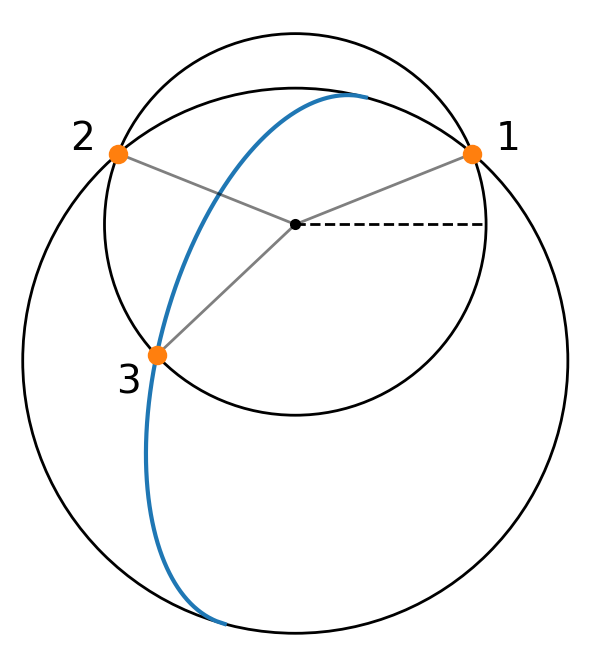

In [78]:
# input
b = 0.5
theta = 75 * np.pi / 180
bo = 0.5
ro = 0.7

# compute the angles
phi = compute_phi(b, theta, bo, ro)

# Plot
ax = plot(b, theta, bo, ro, phi);

The angle $\phi$ is measured counter-clockwise from the line $y = b_o$ (dashed line in the plot). Note that one of the points of intersection (#1) isn't relevant in our case, since it's on the nightside of the planet. The integral we want to compute is the line integral along the occultor limb between points #2 and #3.

In [80]:
phi = phi[[1, 2]]

Here are the two angles for future reference:

In [88]:
for i in range(2):
    display(Latex(r"${:.2f}^\circ$".format(phi[i] * 180 / np.pi)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Numerical evaluation

Now that we can compute `phi`, let's borrow some code from [Greens.ipynb](Greens.ipynb), where we showed how to evaluate $\mathbb{p}^\top$ numerically via Green's theorem. We'll compare our analytic solution to this numerical version.

In [91]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    """
    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        Gx, Gy = G(n)
        return Gx(x(theta), y(theta)) * dx(theta) + Gy(x(theta), y(theta)) * dy(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def pT_numerical(deg, phi, bo, ro):
    """Compute the pT vector numerically from its integral definition."""
    N = (deg + 1) ** 2
    pT = np.zeros(N)
    for n in range(N):
        for phi1, phi2 in phi.reshape(-1, 2):
            x = lambda phi: ro * np.cos(phi)
            y = lambda phi: bo + ro * np.sin(phi)
            dx = lambda phi: -ro * np.sin(phi)
            dy = lambda phi: ro * np.cos(phi)
            pT[n] += primitive(x, y, dx, dy, phi1, phi2, n)
    return pT

## Analytic evaluation

Now let's code up the expression derived in the paper in terms of the vectors $\mathbb{i}$, $\mathbb{j}$, $\mathbb{u}$, and $\mathbb{w}$. We show how to evaluate these vectors analytically in the notebooks
[I.ipynb](I.ipynb), [J.ipynb](J.ipynb), [U.ipynb](U.ipynb), and [W.ipynb](W.ipynb), respectively, so here we'll evaluate them numerically for simplicity.

In [135]:
def A(u, v, i, bo, ro):
    """Compute the Vieta coefficient A_{u, v, i}(bo, ro)."""
    j1 = max(0, u - i)
    j2 = min(u + v - i, u)
    delta = (bo - ro) / (2 * ro)
    return sum(
        [
            float(binom(u, j))
            * float(binom(v, u + v - i - j))
            * (-1) ** (u + j)
            * delta ** (u + v - i - j)
            for j in range(j1, j2 + 1)
        ]
    )


def V(u, v, w, bo, ro, x):
    """Compute the Vieta operator V(x)."""
    res = 0
    u = int(u)
    v = int(v)
    w = int(w)
    for i in range(u + v + 1):
        res += A(u, v, i, bo, ro) * x[u + w + i]
    return res


def computeI(vmax, phi):
    """
    The vector i evaluated by direct numerical integration.
    
    """
    alpha = 0.5 * phi + 0.25 * np.pi
    i = np.zeros(vmax + 1)
    for v in range(vmax + 1):
        for k in range(0, len(alpha), 2):
            func = lambda x: np.sin(x) ** (2 * v)
            i[v] += quad(func, alpha[k], alpha[k + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return i


def computeJ(vmax, bo, ro, phi):
    """
    The vector j evaluated by direct numerical integration.
    
    """
    alpha = 0.5 * phi + 0.25 * np.pi
    k2 = (1 - bo ** 2 - ro ** 2 + 2 * bo * ro) / (4 * bo * ro)
    j = np.zeros(vmax + 1)
    for v in range(vmax + 1):
        for i in range(0, len(alpha), 2):
            func = lambda x: np.sin(x) ** (2 * v) * (1 - np.sin(x + 0j) ** 2 / k2) ** 1.5
            j[v] += quad(func, alpha[i], alpha[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return j


def computeU(vmax, phi):
    """
    The vector u evaluated by direct numerical integration.
    
    """
    alpha = 0.5 * phi + 0.25 * np.pi
    u = np.zeros(vmax + 1)
    for v in range(vmax + 1):
        for i in range(0, len(alpha), 2):
            func = lambda x: np.cos(x) * np.sin(x) ** (2 * v + 1)
            u[v] += quad(func, alpha[i], alpha[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return u


def computeW(vmax, bo, ro, phi):
    """
    The vector w evaluated by direct numerical integration.
    
    """
    alpha = 0.5 * phi + 0.25 * np.pi
    k2 = (1 - bo ** 2 - ro ** 2 + 2 * bo * ro) / (4 * bo * ro)
    w = np.zeros(vmax + 1)
    for v in range(vmax + 1):
        for i in range(0, len(alpha), 2):
            func = (
                lambda x: np.cos(x)
                * np.sin(x) ** (2 * v + 1)
                * (1 + 0j - np.sin(x) ** 2 / k2) ** 1.5
            )
            w[v] += quad(func, alpha[i], alpha[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    return w


def pT(deg, phi, bo, ro):
    """
    Compute the pT integral, evaluated in terms of the integrals i, j, u, and w.
    
    """
    # Initialize
    N = (deg + 1) ** 2
    pT = np.zeros(N) * np.nan
    
    # Pre-compute the helper integrals
    I = computeI(deg + 3, phi)
    J = computeJ(deg + 1, bo, ro, phi)
    U = computeU(2 * deg + 5, phi)
    W = computeW(deg, bo, ro, phi)

    # Pre-compute the p2 term
    p2 = 0
    for i in range(0, len(phi), 2):
        def func(phi):
            sinphi = np.sin(phi)
            z = np.sqrt(1 - ro ** 2 - bo ** 2 - 2 * bo * ro * sinphi)
            return (1.0 - z ** 3) / (1.0 - z ** 2) * (ro + bo * sinphi) * ro / 3.0
        p2 += quad(func, phi[i], phi[i + 1], epsabs=1e-12, epsrel=1e-12,)[0]
    
    for n in range(N):
        
        # Get the mu, nu indices
        l = int(np.floor(np.sqrt(n)))
        m = n - l * l - l
        mu = l - m
        nu = l + m

        # Cases!
        if mu % 2 == 0:
            c = 2 * (2 * ro) ** (l + 2)
            if (mu / 2) % 2 == 0:
                pT[n] = c * V((mu + 4) / 4, nu / 2, 0, bo, ro, I)
            elif (mu / 2) % 2 != 0:
                pT[n] = c * V((mu + 2) / 4, nu / 2, 0, bo, ro, U)
        elif mu == nu == 1:
            pT[n] = p2
        else:
            beta = (1 - (bo - ro) ** 2) ** 1.5
            c = beta * (2 * ro) ** (l - 1)
            if mu == 1:
                if l % 2 == 0:
                    pT[n] = c * (
                        V((l - 2) / 2, 0, 0, bo, ro, J)
                        - 2 * V((l - 2) / 2, 0, 1, bo, ro, J)
                    )
                elif ((l % 2) != 0) and (l != 1):
                    pT[n] = c * (
                        V((l - 3) / 2, 1, 0, bo, ro, J)
                        - 2 * V((l - 3) / 2, 1, 1, bo, ro, J)
                    )
            elif mu > 1:
                if ((mu - 1) / 2) % 2 == 0:
                    pT[n] = c * 2 * V((mu - 1) / 4, (nu - 1) / 2, 0, bo, ro, J)
                elif ((mu - 1) / 2) % 2 != 0:
                    pT[n] = c * 2 * V((mu - 1) / 4, (nu - 1) / 2, 0, bo, ro, W)
        
    return pT

Finally, let's show that the numerical and analytic expressions agree up to degree 5 for the example in Figure 16:

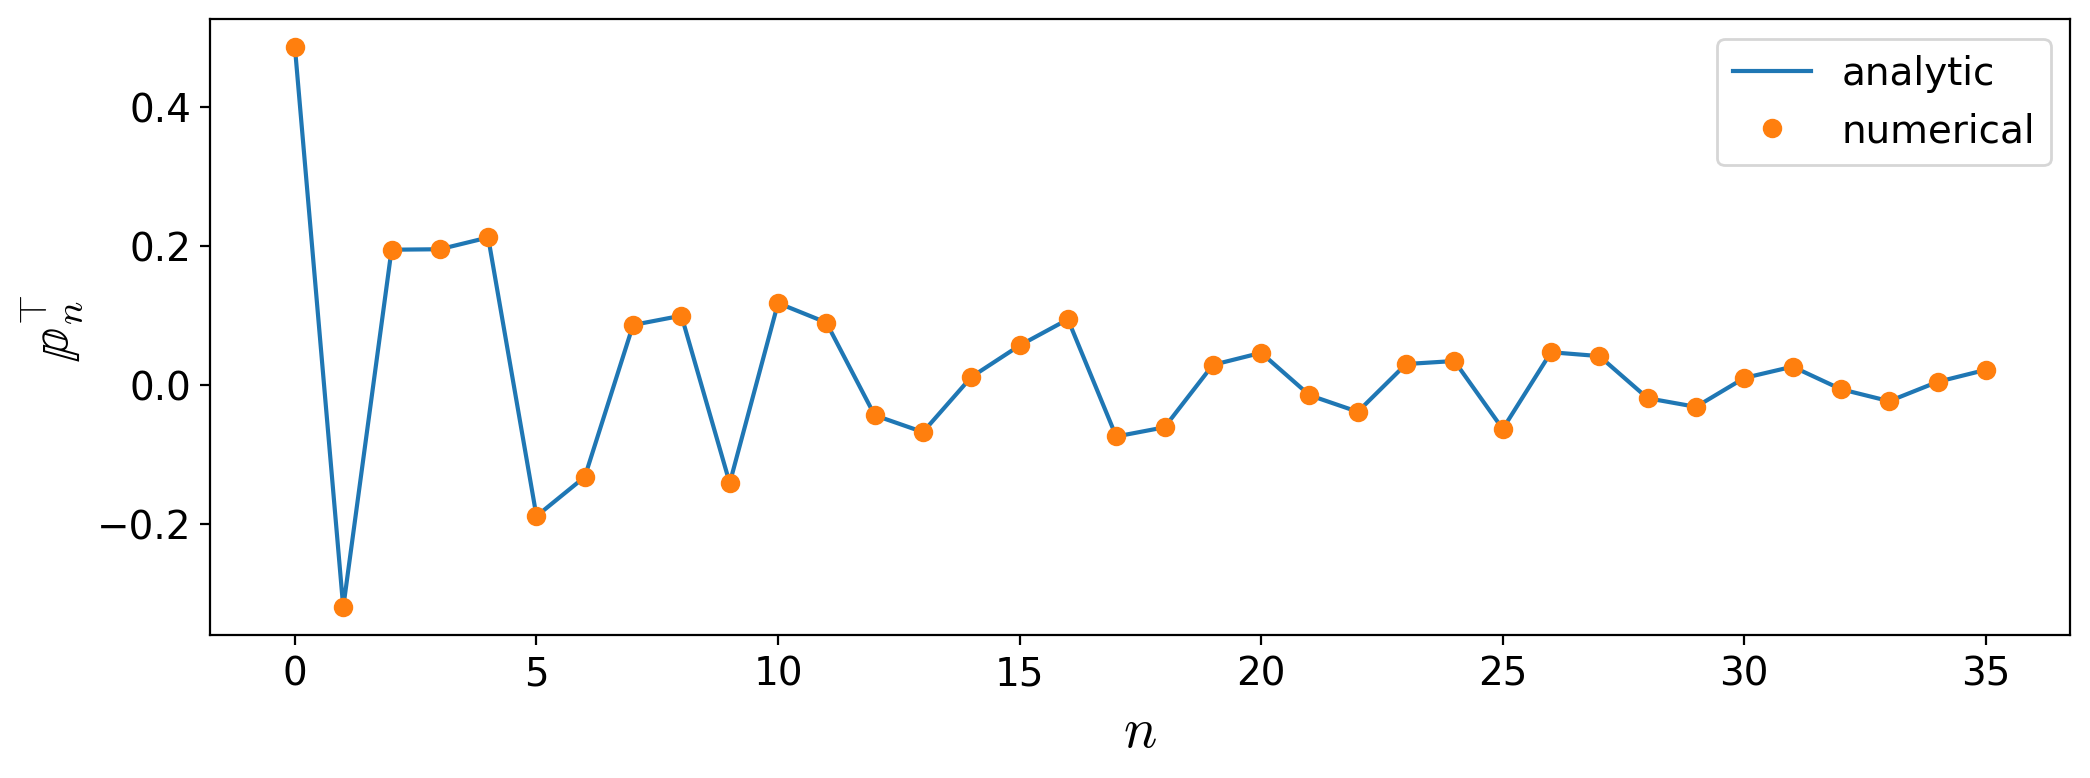

In [137]:
plt.plot(pT(5, phi, bo, ro), label="analytic")
plt.plot(pT_numerical(5, phi, bo, ro), "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$\mathbb{p}_n^\top$", fontsize=20);

The error is at the machine level:

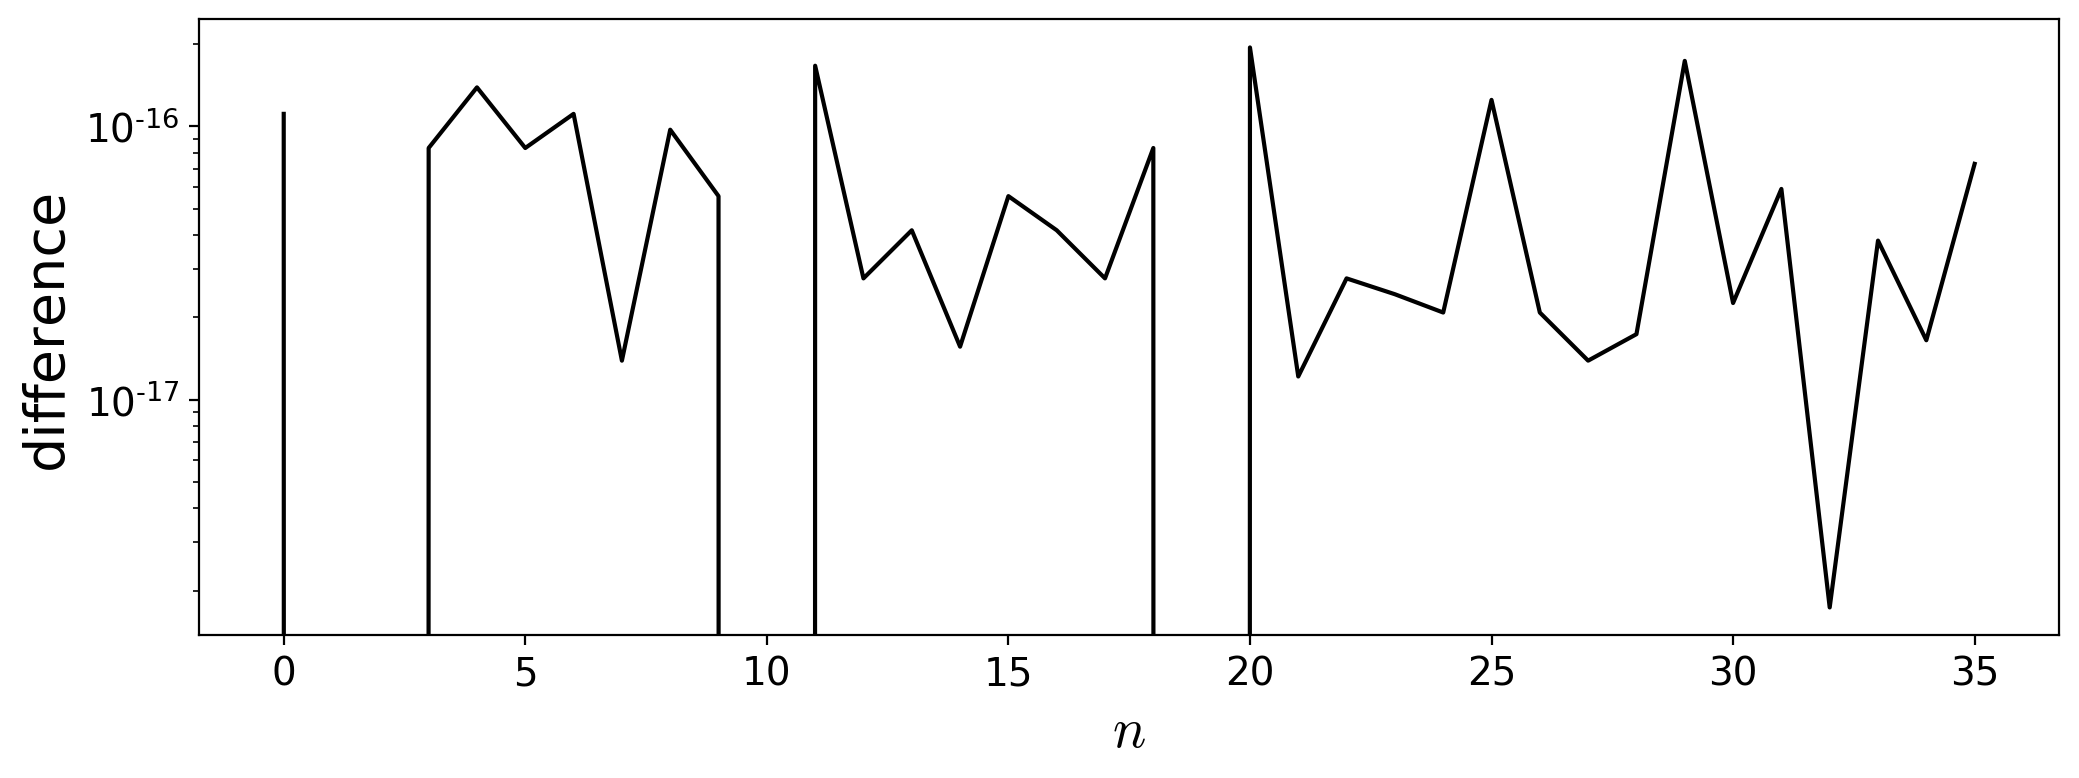

In [138]:
plt.plot(np.abs(pT(5, phi, bo, ro) - pT_numerical(5, phi, bo, ro)), "k-")
plt.xlabel(r"$n$", fontsize=20)
plt.yscale("log")
plt.ylabel(r"difference", fontsize=20);